In [1]:
from models.diffusion import Diffusion
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion = Diffusion(timesteps=1000, beta_schedule="cosine", image_size=128, device=device)

## Оригинал

In [3]:
path = "data/images/1_1X9l-Igmw_000080.jpg"

image = read_image(path)/255.0

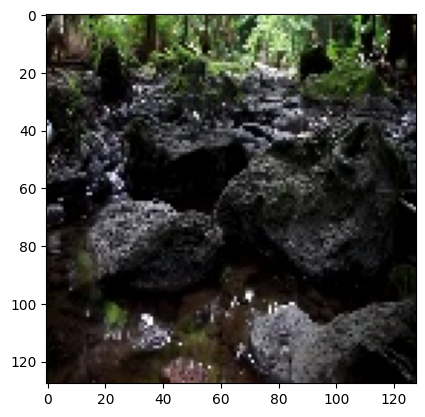

In [4]:
plt.imshow(torch.permute(image, (1,2,0)))

## Прямой процесс дифузии

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6661553..1.3835303].


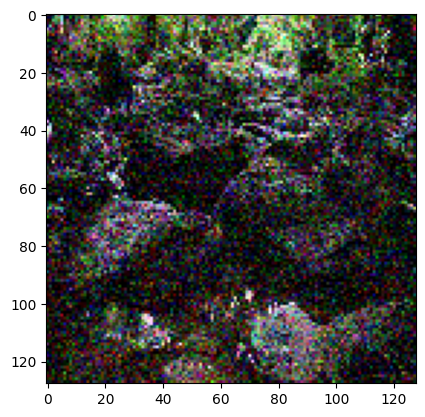

In [5]:
t = 100
noisy_images, noise = diffusion.forward_process(image.unsqueeze(0), torch.tensor(t))

plt.imshow(torch.permute(noisy_images[0], (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


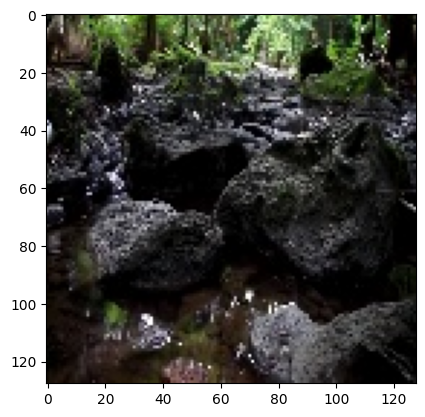

In [6]:
sqrt_one_minus_alpha = diffusion.sqrt_one_minus_alphas_cumprod[t]
sqrt_alpha_cumprod = diffusion.sqrt_alphas_cumprod[t]

denoise = (noisy_images - noise * sqrt_one_minus_alpha)/sqrt_alpha_cumprod

plt.imshow(torch.permute(denoise[0], (1,2,0)))

## Обратный процесс дифузии

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67624575..1.373947].


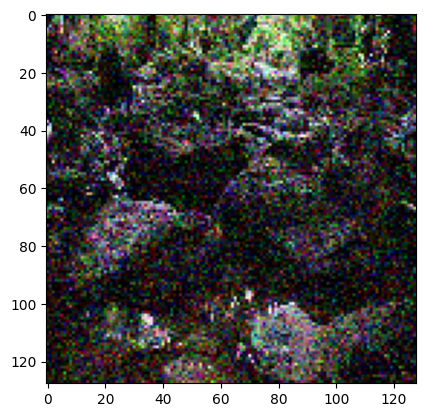

In [7]:
x_denoise = diffusion.ddim_step(x = noisy_images, pred_noise = noise, t = torch.tensor(t), i = t, eta = 0.5)

plt.imshow(torch.permute(x_denoise[0], (1,2,0)))

In [8]:
# loss with single ddim_step step
F.mse_loss(x_denoise.clamp(0, 1), image.unsqueeze(0))

tensor(0.0195)

In [9]:
# loss without dinoising
F.mse_loss(noisy_images.clamp(0, 1), image.unsqueeze(0))

tensor(0.0198)

In [10]:
# это не так работает, но принцип схожий
x_denoise_it = noisy_images
for _ in range(30):
    x_denoise_it = diffusion.ddim_step(x = x_denoise_it, pred_noise = noise, t = torch.tensor(t), i = t, eta = 0.0)

In [11]:
F.mse_loss(x_denoise_it.clamp(0, 1), image.unsqueeze(0))

tensor(0.0111)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48179018..1.237102].


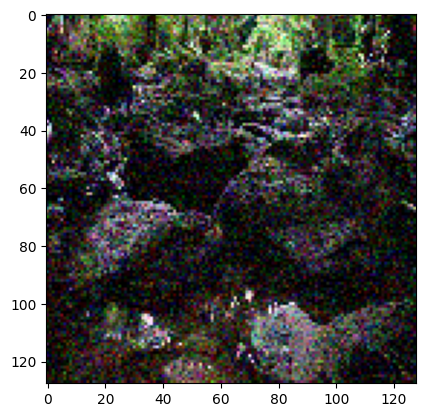

In [12]:
plt.imshow(torch.permute(x_denoise_it[0], (1,2,0)))

## мда... проверим как работает ddpm_step

In [13]:
x_denoise = diffusion.ddpm_step(x = noisy_images, pred_noise = noise, t = torch.tensor(t), i = t)

F.mse_loss(x_denoise.clamp(0, 1), image.unsqueeze(0))

tensor(0.0194)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6639505..1.3840244].


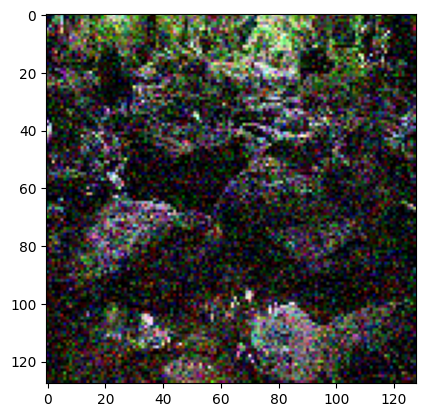

In [14]:
plt.imshow(torch.permute(x_denoise[0], (1,2,0)))

## Обратный процесс целиком по идеальному шуму

In [15]:
# сохраняем все шаги прямого процесса
# проводим все шаги обратного процесса по идеальному шуму

noisy_images = []
noises = []

for t in range(0,1000):
    noisy_image, noise = diffusion.forward_process(image.unsqueeze(0), torch.tensor(t))
    noisy_images.append(noisy_image)
    noises.append(noise)

In [30]:
losses = []
orig = []

x = diffusion.ddim_step(noisy_images[-1], noises[-1], t=torch.tensor(999), i=999, eta=0.0)

losses.append(F.mse_loss(x.clamp(0, 1), image.unsqueeze(0)))
orig.append(F.mse_loss(noisy_images[-1].clamp(0, 1), image.unsqueeze(0)))

for t in range(0,999)[::-1]:
    x = diffusion.ddim_step(x, noises[t], t=torch.tensor(t), i=t, eta=0.0)
    losses.append(F.mse_loss(x.clamp(0, 1), image.unsqueeze(0)))
    orig.append(F.mse_loss(noisy_images[t].clamp(0, 1), image.unsqueeze(0)))

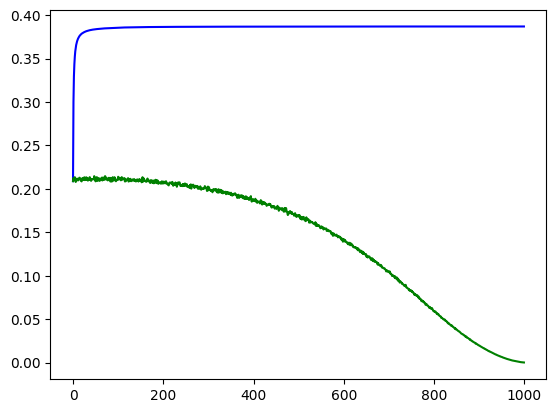

In [31]:
plt.plot(losses[:], color='b')
plt.plot(orig[:], color='g')